# CNN - MLP - train model with regression problematic 

In [22]:
def mlp_lr_sm(paths, features, y_label, ndvi_low, ndvi_high, allow_frozen_state,loss_function, optimizer, metrics):
    """
    Arguments:
    """
    
    
    # Import modules
    from glob import glob
    import datetime as dt
    import geopandas as gpd
    import pandas as pd
    import seaborn as sns
    
    
    ## Initialize data
    # Files with data
    paths = glob(paths)
    paths.sort()

    # Create Station id linked with filepath
    ids = [x.split('\\')[-1].split('_')[0] for x in paths]
    files = dict(zip(ids,paths))

    # Load all files into one Dataframe
    gdf = gpd.tools.util.pd.concat(map(gpd.read_file, paths), ignore_index=True)
    print(f'Rows before preprocessing {len(gdf)}')
    
    
    ## Preprocessing
    # Set type of date column to datetime object
    gdf.date = gdf.date.astype('datetime64[ns]')
    
    #Drop rows without Sentinel 2 data
    gdf.dropna(how='any',subset=['NDVI'], inplace=True)
    
    # Convert int to timedelta in days 
    s2_timedelta = [dt.timedelta(days=x) for x in gdf.s2_distance]  #cast as float to convert none to nan

    gdf.s2_distance = s2_timedelta
    
    #Remove uneseccary columns
    gdf.drop(labels = ['CloudMask'], axis = 1, inplace = True)

    # Clean Nan Values within subset columns (major variables to inspect)
    gdf.dropna(how='any', subset=['soil_moisture', 'VV'], inplace=True)

    # Drop lower and upper 1% of data to eliminate outliers
    gdf = gdf[gdf.soil_moisture.gt(gdf.soil_moisture.quantile(0.01)) & gdf.soil_moisture.lt(gdf.soil_moisture.quantile(0.99))]
    gdf = gdf[gdf.VV.gt(gdf.VV.quantile(0.01)) & gdf.VV.lt(gdf.VV.quantile(0.99))]
    gdf = gdf[gdf.NDVI.gt(gdf.NDVI.quantile(0.01)) & gdf.NDVI.lt(gdf.NDVI.quantile(0.99))]

    # Remove rows where ndvi is older than 30days
    gdf = gdf[gdf.s2_distance.gt(dt.timedelta(days=-7)) & gdf.s2_distance.lt(dt.timedelta(days=7))]
    
    # Remove NDVI values outside range because to high ndvi means to dense vegetation and vv is disturbed too much 
    if None not in [ndvi_low, ndvi_high]:
        gdf = gdf[gdf.NDVI.between(ndvi_low,ndvi_high)]
    
    # Remove rows where Temperature is below Zero 273,15 K because VV is in frozen soils not trustworth
    if allow_frozen_state == 'no':
        gdf = gdf[gdf.minimum_2m_air_temperature.gt(273,15)]

    # Select only sm and vv meassurements where soil is not in frozen state
    print(f'Rows after preprocessing {len(gdf)}')
    
    
    ## One Hot Encoding
    # Drop categorical data 
    orbit = gdf.pop('orbit')
    platform = gdf.pop('platform')
    
    gdf['ASCENDING'] = (orbit == 'ASCENDING')*1
    gdf['DESCENDING'] = (orbit == 'DESCENDING')*1

    gdf['Sentinel_A'] = (platform == 'A')*1
    gdf['Sentinel_B'] = (platform == 'B')*1
    
    
    ## Statistics
    #KDE Plot
    #plot_kde = sns.pairplot(gdf[features], diag_kind = 'kde')
    #print(plot_kde)
    
    # Dataframe Statistics 
    train_stats = gdf[features].describe()
    train_stats.pop(y_label)
    train_stats = train_stats.transpose()
    #print(train_stats)
    
    
    ## Split into Train and Test 
    df = pd.DataFrame(gdf[features]).reset_index(drop=True)
    train_df = df.sample(frac = 0.8, random_state=0)
    test_df = df.drop(train_df.index)
    
    train_labels = train_df.pop(y_label)
    test_labels = test_df.pop(y_label)
    
    ## Normalize data
    def norm(x):
        return (x - train_stats['mean']) / train_stats['std']
    
    n_train_df = norm(train_df)
    n_test_df = norm(test_df)
    
    
    ## The Model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras import layers
    from tensorflow.nn import relu
    from tensorflow.keras.optimizers import RMSprop
    from keras.callbacks import Callback
    from tensorflow.keras.callbacks import EarlyStopping
    
    #Architecture 
    def build_model(optimizer):
        model = Sequential([
            layers.Dense(64, activation=relu, input_shape=[len(n_train_df.keys())]), # densly (fully connected) hidden layer
            layers.Dense(64, activation=relu), # denly hidden layer
            layers.Dense(1) #output layer
        ])

        if optimizer == 'RMSprop':
            optimizer = RMSprop(0.001)

        model.compile(
            loss = loss_function, # https://keras.io/api/losses/
            optimizer = optimizer, #https://keras.io/api/optimizers/#available-optimizers
            metrics = metrics) 

        return model
    
    model = build_model(optimizer)
    
    #Inspect Model
    model_summary = model.summary()
    
    
    ## Train the model
    # Callbacks
    """
    class Calls(Callback):
        #Print dot every epoch while training
        def on_epoch_end(self, epoch, logs):
            if epoch % 100 == 0: print('')
            print('.', end='')
    """
    # stop the training when there is no improvement in the loss for three consecutive epochs.
    stop_improving = EarlyStopping(monitor='val_loss', patience=10)
    
    EPOCHS = 1000

    history = model.fit(
        x = n_train_df,
        y = train_labels,
        epochs = EPOCHS,
        validation_split = 0.2, 
        verbose = 0,
        callbacks = [stop_improving]) # Calls()
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    print(hist.tail())
    
    import matplotlib.pyplot as plt

    def plot_history(hitsory):
        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch

        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Mean Abs Error [m^3/m^3]')
        plt.plot(hist['epoch'], hist['mae'],
                label = 'Train Error')
        plt.plot(hist['epoch'], hist['val_mae'],
                label = 'Val Error')
        plt.legend()
        plt.ylim([0,hist['mae'].max() + hist['mae'].max() * 0.5])

        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Mean Square Error [m^3/m^3^2]')
        plt.plot(hist['epoch'], hist['mse'],
                label = 'Train Error')
        plt.plot(hist['epoch'], hist['val_mse'],
                label = 'Val Error')
        plt.legend()
        plt.ylim([0,hist['mse'].max() + hist['mse'].max() * 0.5])

    plot_history(history)
    print(f'metrics_names : {model.metrics_names}')
    loss, mae, mse, accuracy = model.evaluate(n_test_df, test_labels, verbose = 0)
    print("Testing set Mean Abs Error: {:5.2f} m^3/m^3".format(mae))
    print("Testing set Mean squared Error: {:5.2f} m^3/m^3".format(mse))
    print("Testing set Accuracy: {:5.2f} m^3/m^3".format(accuracy))

    ## Make Predictions
    test_predictions = model.predict(n_test_df).flatten()
    
    plt.figure()
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values m^3/m^3')
    plt.ylabel('Predictions m^3/m^3')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,0.5])
    plt.ylim([0,0.5])
    plot_predict_scatter = plt.plot([-100,100], [-100,100])
    print(plot_predict_scatter)
    
    plt.figure()
    error = test_predictions - test_labels
    plt.hist(error, bins=25)
    plt.xlabel('Prediction Error m^3/m^3')
    plot_error_hist = plt.ylabel('Count')
    print(plot_error_hist)
    

Rows before preprocessing 79938
Rows after preprocessing 4857
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                384       
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________
    loss       mae       mse  accuracy  val_loss   val_mae  val_mse  \
6    0.0  0.423753  0.204183       0.0       0.0  0.416195   0.1986   
7    0.0  0.423753  0.204183       0.0       0.0  0.416195   0.1986   
8    0.0  0.423753  0.204183       0.0       0.0  0.416195   0.1986   
9    0.0  0.423754  0.204183       0

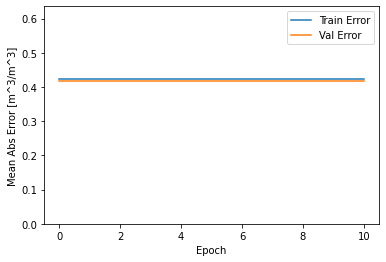

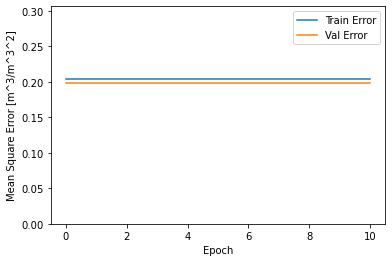

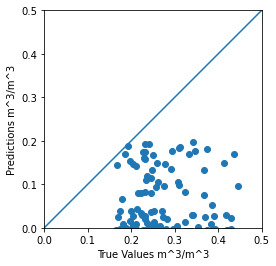

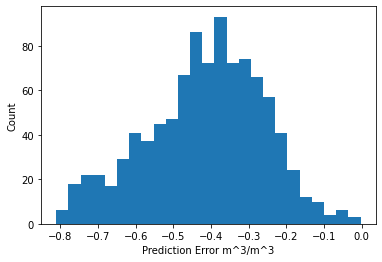

In [23]:
mlp_lr_sm(
    paths = 'C://Users/USER/Desktop/Master_Irrigation/03_GIS/ground_trouth/sentinel_ismn_data/*',
    features = ['VV', 'ASCENDING','DESCENDING','Sentinel_A','Sentinel_B', 'soil_moisture'],
    y_label = 'soil_moisture',
    ndvi_low = None, 
    ndvi_high = None, 
    allow_frozen_state = 'yes',
    loss_function = 'sparse_categorical_crossentropy',       # 'mae', 'sparse_categorical_crossentropy'
    optimizer =  'adam',    # 'RMSprop', 
    metrics = ['mae', 'mse', 'accuracy']
    )

Rows before preprocessing 36291
Rows after preprocessing 4303
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 64)                1984      
_________________________________________________________________
dense_58 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 65        
Total params: 6,209
Trainable params: 6,209
Non-trainable params: 0
_________________________________________________________________
         loss       mae       mse  accuracy  val_loss   val_mae   val_mse  \
349  0.049412  0.049412  0.004250       0.0  0.052462  0.052462  0.004675   
350  0.049405  0.049405  0.004250       0.0  0.052482  0.052482  0.004676   
351  0.049399  0.049399  0.004249       0.0  0.052471  0.052471  0.004676   
352  0.0493

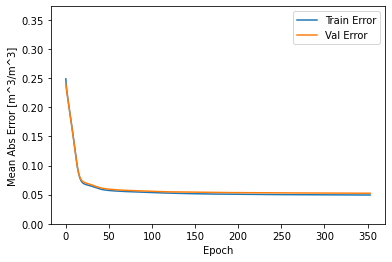

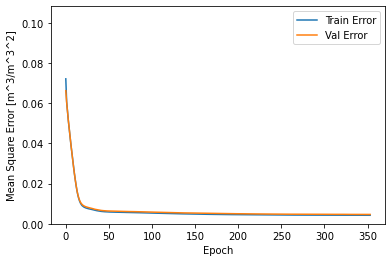

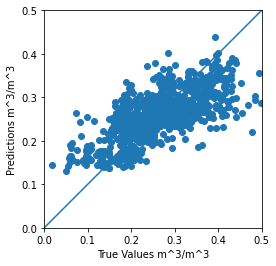

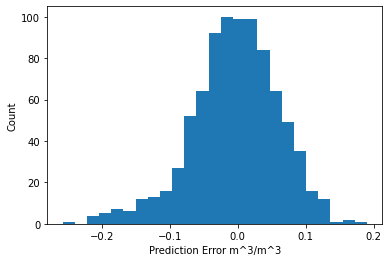

In [36]:
mlp_lr_sm(
    paths = 'C://Users/USER/Desktop/Master_Irrigation/03_GIS/ground_trouth/CNN_data/*',
    features = ['VV','VH', 'ASCENDING','DESCENDING','Sentinel_A','Sentinel_B','angle',
                'NDVI','Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 
                'RedEdge3', 'RedEdge4','WaterVapor','NIR',
                'dewpoint_2m_temperature','maximum_2m_air_temperature', 
                'mean_2m_air_temperature', 'minimum_2m_air_temperature', 
                'surface_pressure','total_precipitation','u_component_of_wind_10m', 
                'v_component_of_wind_10m',
                'elevation','clay', 'sand', 'silt',
                'soil_moisture'],
    y_label = 'soil_moisture',
    ndvi_low = 0, 
    ndvi_high = 0.7, 
    allow_frozen_state = 'no',
    loss_function = 'mae',       # 'mae', 'sparse_categorical_crossentropy'
    optimizer =  'Ftrl',    # Ftrl adam, Adamax Nadam  'RMSprop',  SGD  RMSprop  Adam  Adadelta  Adagrad         
    metrics = ['mae', 'mse', 'accuracy']
    )

In [ ]:
mlp_lr_sm(
    paths = 'C://Users/USER/Desktop/Master_Irrigation/03_GIS/ground_trouth/sentinel_ismn_data/*',
    features = ['VV', 'ASCENDING','DESCENDING','Sentinel_A','Sentinel_B','NDVI','angle', 'soil_moisture'],
    y_label = 'soil_moisture'
    )

In [ ]:
mlp_lr_sm(
    paths = 'C://Users/USER/Desktop/Master_Irrigation/03_GIS/ground_trouth/sentinel_ismn_data/*',
    features = ['VV', 'ASCENDING','DESCENDING','Sentinel_A','Sentinel_B','NDVI','angle','ismn_id', 'soil_moisture'],
    y_label = 'soil_moisture'
    )

In [ ]:
mlp_lr_sm(
    paths = 'C://Users/USER/Desktop/Master_Irrigation/03_GIS/ground_trouth/sentinel_ismn_data/*',
    features = ['VV','VH', 'ASCENDING','DESCENDING','Sentinel_A','Sentinel_B','NDVI','angle','ismn_id', 'soil_moisture'],
    y_label = 'soil_moisture'
    )

In [ ]:
mlp_lr_sm(
    paths = 'C://Users/USER/Desktop/Master_Irrigation/03_GIS/ground_trouth/sentinel_ismn_data/*',
    features = ['VV','VH', 'ASCENDING','DESCENDING','Sentinel_A','Sentinel_B','NDVI','angle','ismn_id','WaterVapor', 'soil_moisture'],
    y_label = 'soil_moisture'
    )

In [ ]:
mlp_lr_sm(
    paths = 'C://Users/USER/Desktop/Master_Irrigation/03_GIS/ground_trouth/sentinel_ismn_data/*',
    features = ['VV','VH', 'ASCENDING','DESCENDING','Sentinel_A','Sentinel_B','NDVI','angle','ismn_id','WaterVapor','NIR', 'soil_moisture'],
    y_label = 'soil_moisture'
    )

In [ ]:
mlp_lr_sm(
    paths = 'C://Users/USER/Desktop/Master_Irrigation/03_GIS/ground_trouth/sentinel_ismn_data/*',
    features = ['VV','VH', 'ASCENDING','DESCENDING','Sentinel_A','Sentinel_B','NDVI','angle','ismn_id','Aerosols', 'Blue',
       'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'RedEdge4','WaterVapor','NIR', 'soil_moisture'],
    y_label = 'soil_moisture'
    )

In [ ]:
mlp_lr_sm(
    paths = 'C://Users/USER/Desktop/Master_Irrigation/03_GIS/ground_trouth/sentinel_ismn_data/*',
    features = ['VV','VH', 'ASCENDING','DESCENDING','Sentinel_A','Sentinel_B','NDVI','angle','Aerosols', 'Blue',
       'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'RedEdge4','WaterVapor','NIR', 'soil_moisture'],
    y_label = 'soil_moisture',
    ndvi_low = None,
    ndvi_high = None,
    allow_frozen_state = 'yes',
    )

In [ ]:
mlp_lr_sm(
    paths = 'C://Users/USER/Desktop/Master_Irrigation/03_GIS/ground_trouth/CNN_data/*',
    features = ['VV', 'ASCENDING','DESCENDING','Sentinel_A','Sentinel_B', 'soil_moisture'],
    y_label = 'soil_moisture'
    )

In [ ]:
mlp_lr_sm(
    paths = 'C://Users/USER/Desktop/Master_Irrigation/03_GIS/ground_trouth/CNN_data/*',
    features = ['VV','VH', 'ASCENDING','DESCENDING','Sentinel_A','Sentinel_B','NDVI','angle','Aerosols', 'Blue',
       'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'RedEdge4','WaterVapor','NIR','dewpoint_2m_temperature',
       'maximum_2m_air_temperature', 'mean_2m_air_temperature',
       'minimum_2m_air_temperature', 'surface_pressure', 'total_precipitation',
       'u_component_of_wind_10m', 'v_component_of_wind_10m', 'soil_moisture' ],
    y_label = 'soil_moisture',
    ndvi_low = 0,
    ndvi_high = 0.7
    )

In [ ]:
mlp_lr_sm(
    paths = 'C://Users/USER/Desktop/Master_Irrigation/03_GIS/ground_trouth/CNN_data/*',
    features = ['VV','VH', 'ASCENDING','DESCENDING','Sentinel_A','Sentinel_B','NDVI','angle','Aerosols', 'Blue',
       'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'RedEdge4','WaterVapor','NIR','dewpoint_2m_temperature',
       'maximum_2m_air_temperature', 'mean_2m_air_temperature',
       'minimum_2m_air_temperature', 'surface_pressure','total_precipitation',
       'u_component_of_wind_10m', 'v_component_of_wind_10m', 'soil_moisture' ],
    y_label = 'soil_moisture',
    ndvi_low = 0,
    ndvi_high = 0.5
    )

## Print Function names with arguments

In [ ]:
from inspect import getmembers, isfunction, signature
import numpy

def explain(m):
    try:
        return f"{m[0]}{signature(m[1])}"
    except:
        return f"{m[0]}(???)" # some functions don't provide signature

print(*(explain(m) for m in getmembers(irrigation_detection, isfunction)), sep='\n')